# A quick demo of `expt`

DISCLAIMER: Everything (including API and default behaviors) is subject to change.

## 0. Data Preparation Part (can be skipped)

Let's grab some raw training log data of training DQN agents that is publicly available:

https://github.com/openai/baselines-results/blob/master/dqn_results.ipynb

In [ ]:
# https://github.com/openai/baselines-results/blob/master/dqn_results.ipynb
results_url = "https://openaisciszymon.blob.core.windows.net/dqn-blogpost/results.pkl"
download_path = "dqn_results.pkl"
! [ -e "{download_path}" ] || curl -L {results_url} -o {download_path}

with open(download_path, "rb") as f:
    import pickle
    run_to_episode_data = pickle.load(f)

Let's convert this pickle data into a CSV file, one into each directory.

In [ ]:
import pandas as pd
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda _: _

for k in tqdm(sorted(run_to_episode_data.keys())):
    df = pd.DataFrame(run_to_episode_data[k]['episode_data'])
    os.makedirs(f"data/{k}", exist_ok=True)
    df.to_csv(f"data/{k}/progress.csv", index=False)

print(f"Total number of directories = {len(run_to_episode_data)}")

In [1]:
!ls data/ | head -n6

atari-a-alien-123
atari-a-alien-456
atari-a-alien-789
atari-a-amidar-123
atari-a-amidar-456
atari-a-amidar-789


## 1. Setup

In [2]:
%load_ext autoreload
%aimport expt.data
%aimport expt.plot
%autoreload 1
from importlib import reload

In [3]:
%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from IPython.core.pylabtools import figsize

mpl.rcParams['pdf.fonttype'] = 42     # use true-type
mpl.rcParams['ps.fonttype'] = 42     # use true-type
mpl.rcParams['font.size'] = 12

%config InlineBackend.figure_format = 'retina'

In [4]:
import expt
print(expt.__version__)

import pandas as pd
import numpy as np

0.1.0


## 2. Data Loading

The `expt.get_runs` function parses training directories in parallel, giving a sequence of `Run` objects.

It can parse a directory that contains CSV files (e.g. `progress.csv`) or tensorboard event files.

In [5]:
expt.get_runs?

Signature: expt.get_runs(*path_globs, verbose=False, n_jobs=8, fillna=True) -> List[expt.data.Run]
Docstring:
Get a list of Run objects from the given path(s).
Runs in parallel.
File:      ~/workspace/dev/expt/expt/data.py
Type:      function


In [6]:
run = expt.get_runs("./data/atari-prior-duel-a-alien-*")
run[0]

Run(./data/atari-prior-duel-a-alien-123, df with 40799 rows)

In [7]:
run[0].df

,initial_reset_time,episode_rewards,episode_lengths,episode_end_times
0,0,190.0,2879,4.581740
1,0,250.0,2395,7.680398
2,0,180.0,3411,11.984523
3,0,140.0,2615,15.358311
4,0,240.0,2755,18.986382
...,...,...,...,...
40794,0,4080.0,6790,682605.500080
40795,0,3210.0,5676,682623.048560
40796,0,1020.0,4055,682635.724665
40797,0,2630.0,6202,682655.405495


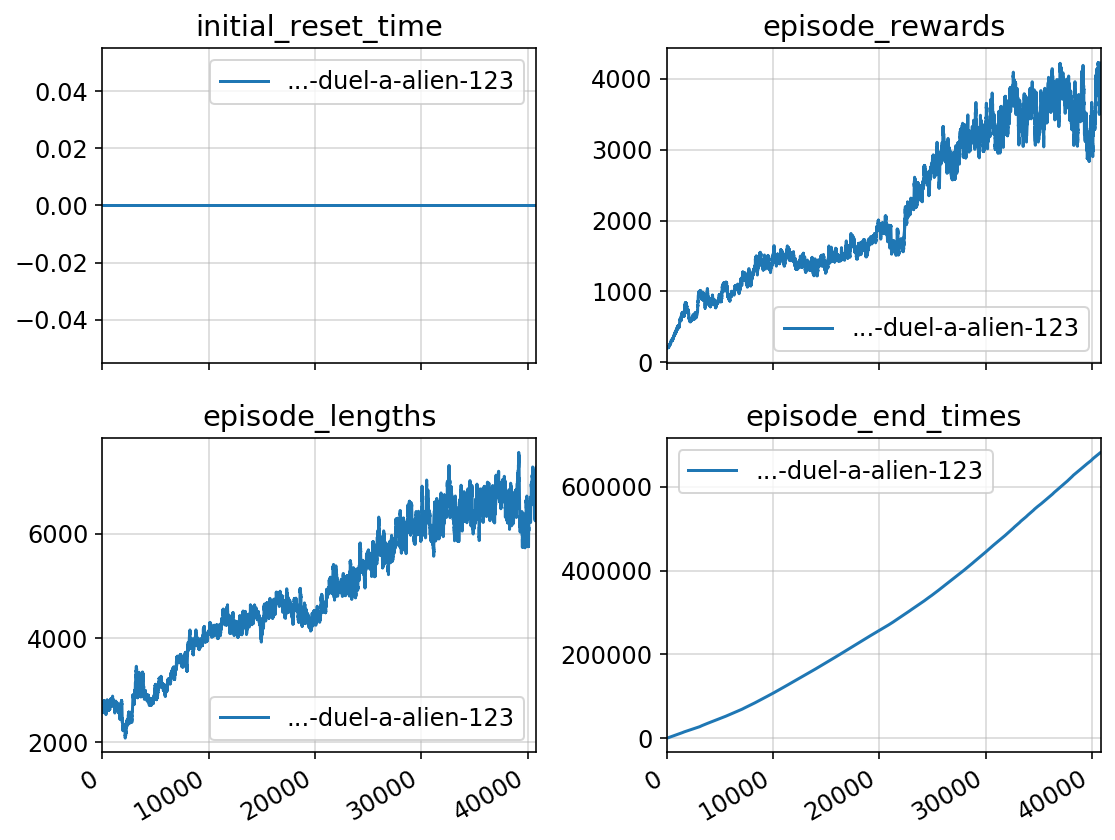

In [8]:
# Let's look at one run
run[0].plot(rolling=100);

### Experiment Data Construction

In [9]:
ex = expt.Experiment("Comparison of DQN Variants")
env = 'amidar'

for algo, desc in {"a": "DQN",
                   "duel-a": "Double DQN",
                   "prior-a": "DQN + PER",
                   "prior-duel-a": "Double DQN + PER",
                  }.items():
    runs = expt.get_runs(f"./data/atari-{algo}-{env}-*")
    for r in runs:
        # This should be our x-axis. Note that this might be not aligned across different runs
        r.df['total_timesteps'] = r.df['episode_lengths'].cumsum()
    
    #h = expt.Hypothesis(name=desc, runs=runs)
    #ex.add_hypothesis(h)
    ex.add_runs(desc, runs=runs)

## 3. Plotting using Data API

In [10]:
expt.Hypothesis.plot?

Init signature: expt.Hypothesis.plot(hypothesis: 'Hypothesis')
Docstring:     
Hypothesis.plot based on matplotlib.

This can work in two different modes:
(1) Plot (several or all) columns as separate subplots (subplots=True)
(2) Plot (several or all) columns in a single axesplot (subplots=False)

Additional keyword arguments:
    - rolling (int): A window size for rolling and smoothing.
    - n_samples (int): If given, we subsample using n_samples number of
      equidistant points over the x axis. Values will be interpolated.
    - std_alpha (float): If not None, will show the 1-std range as a
      shaded area. Defaults 0.2 (enabled).
    - runs_alpha (float): If not None, will draw an individual line
      for each run. Defaults None (disabled), recommend value 0.2.

All other kwargs is passed to DataFrame.plot(). For example, you may
find the following parameters useful:
    `x`, `y`, `layout`, `figsize`, `ax`, `legend`, etc.
File:           ~/workspace/dev/expt/expt/plot.py
Type:

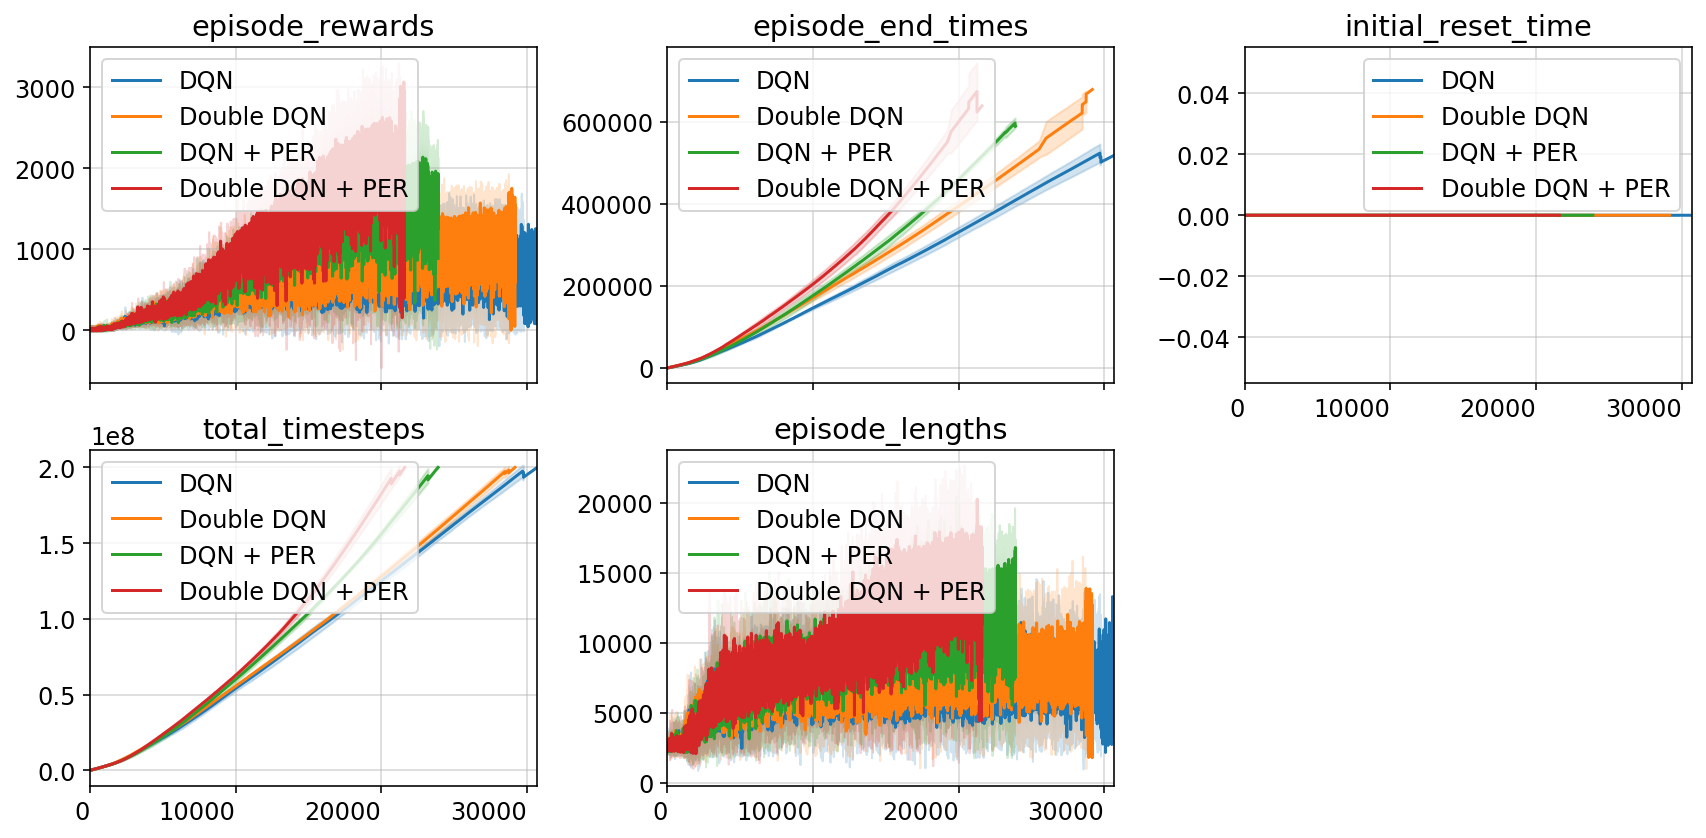

In [11]:
ex.plot();

This default one doesn't look as good -- but should be much better than the default behavior of `DataFrame.plot()`.

We can pass sensible arguments like `DataFrame.plot()`. Other useful ones are `rolling` and `n_samples`, which allow better appearance and faster plotting by sub-sampling and interpolation of the data (it also helps to deal with a x-axis that is not aligned over different random seeds). 1-std confidence interval is enabled by default (see `std_alpha`).

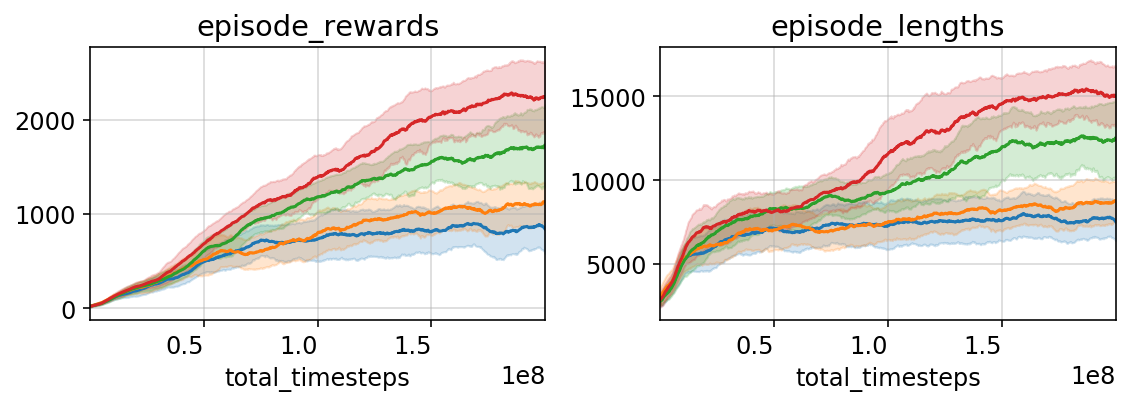

In [12]:
g = ex.plot(x='total_timesteps', y=['episode_rewards', 'episode_lengths'],
            rolling=50, n_samples=1000, legend=False)

Hypothesis(DQN, <3 runs>)


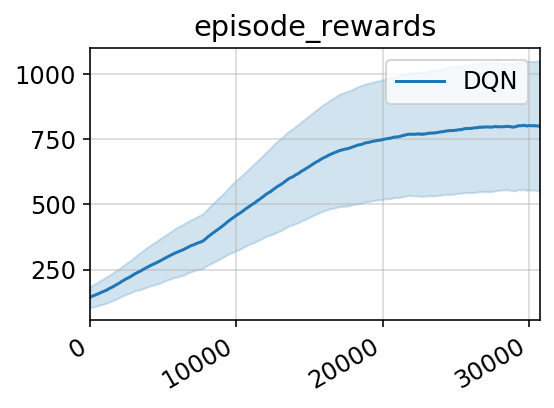

In [13]:
h = ex.hypotheses[0]
print(h)
h.plot(rolling=500, n_samples=1000, y='episode_rewards');

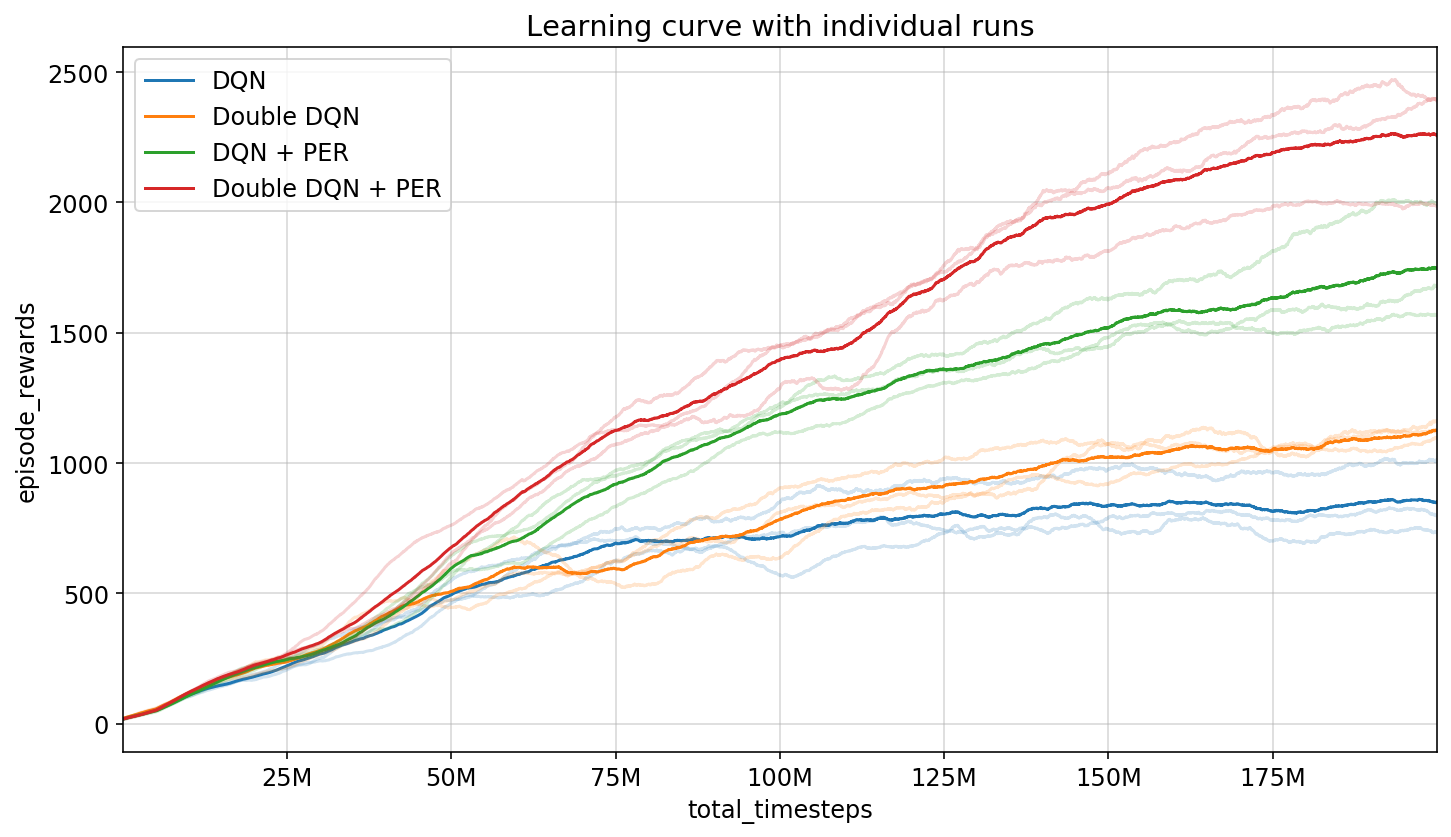

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

ex.plot(x='total_timesteps', y='episode_rewards',
        rolling=500, n_samples=10000,
        runs_alpha=0.2, std_alpha=None,
        ax=ax);

# further customization using matplotlib API
ax.set_title("Learning curve with individual runs")
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{0:g}M'.format(x / 1e6)))

## 4. Holoviews (Experimental)

Matplotlib is great, but slow. Interactive plotting libraries such as `bokeh`, `plotly` would be awesome. For now, we provide a high-level API based on hvplot (Holoviews) with almost similar interfaces.

In [ ]:
# Holoviews+Plotly.express extension (faster than matplotlib)
import hvplot.pandas
import holoviews as hv
hv.extension("plotly")
hv.output(backend="plotly")           # 'bokeh' is also possible, but plotly works best

import plotly.io as pio
pio.templates.default = "none"

In [ ]:
p = ex.hvplot(x="total_timesteps", 
              y=["episode_rewards", "episode_lengths"],
              rolling=500, n_samples=5000,
              std_alpha=0,
             ).opts(width=500, height=300).cols(2)
p